<a href="https://colab.research.google.com/github/rachelradical/rachelradical.github.io/blob/main/VAERS_Covid_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! Within this notebook, you'll find an exploratory analysis into Covid-19 vaccine data. VAERS, which stands for Vaccine Adverse Effect Reporting System, is the only official nationwide database of vaccine adverse events.

Although the data within is sometimes disregarded as anecdotal or unreliable, there is plenty of evidence to the contrary. It is not perfect; adverse events often go unreported - especially mild ones, and anyone can make a report to VAERS without restriction. However, VAERS remains the best tool we have to act as an early warning system to identify adverse events and safety concerns that need further study using more robust data systems.

For more information, please visit the official [VAERS website](https://vaers.hhs.gov/).

In [3]:
from google.colab import drive
import os
import pandas as pd

# Load data from google drive
drive.mount('/content/drive', force_remount=True)
directory = '/content/drive/My Drive/VAERS2021to2024/'

vax_data = {}
data_data = {}
symptoms_data = {}

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        try:
            df = pd.read_csv(filepath, encoding='latin1', low_memory=False)
        except UnicodeDecodeError:
            print(f"Error reading {filename}. Trying a different encoding.")
            df = pd.read_csv(filepath, encoding='iso-8859-1', low_memory=False)

        # Sort data into correct dictionary, identifying them by year
        if 'VAERSVAX' in filename:
            year = filename[:4]
            vax_data[year] = df
        elif 'VAERSDATA' in filename:
            year = filename[:4]
            data_data[year] = df
        elif 'VAERSSYMPTOMS' in filename:
            year = filename[:4]
            symptoms_data[year] = df

# List to store merged dataframes for each year
merged_years = []

# Function to merge dataframes and handle duplicate columns
def merge_dataframes(data_df, vax_df, symptoms_df):

    merged_df = data_df.merge(vax_df, on='VAERS_ID', suffixes=('', '_vax'))
    merged_df = merged_df.merge(symptoms_df, on='VAERS_ID', suffixes=('', '_symptoms'))

    duplicate_columns = [col for col in merged_df.columns if col.endswith('_vax') or col.endswith('_symptoms')]
    merged_df.drop(columns=duplicate_columns, inplace=True)

    return merged_df

# Merge dataframes for each year and add a "year" column
for year in data_data.keys():
    if year in vax_data and year in symptoms_data:
        try:
            merged_df = merge_dataframes(data_data[year], vax_data[year], symptoms_data[year])
            merged_df['year'] = year
            merged_years.append(merged_df)
        except KeyError as e:
            print(f"Error merging data for year {year}: {e}")

all_years_df = pd.concat(merged_years, ignore_index=True)



Mounted at /content/drive


Now, we can filter out the data corresponding to Covid 19 vaccines.

In [63]:
# Filter the dataframe for COVID-19 vaccine data
covid_data_df = all_years_df[all_years_df['VAX_TYPE'] == 'COVID19']

# Drop unneccessary columns
covid_data_df = covid_data_df.drop(columns=['CAGE_YR', 'CAGE_MO'])
covid_data_df.drop(covid_data_df.filter(regex='SYMPTOMVERSION').columns, axis=1, inplace=True)
covid_data_df = covid_data_df[covid_data_df['SYMPTOM1'] != 'No adverse event']

# Display the first few rows of the filtered dataframe, and find out the number of adverse reports.
print(covid_data_df.head())
print(f"Number of COVID-19 vaccine records: {len(covid_data_df)}")

# Group by the "year" column, count and display the number of entries for each year
yearly_counts = covid_data_df.groupby('year').size()
print(yearly_counts)

# Optional - Un-comment this block to save the COVID DataFrame to a CSV file in Google Drive
#output_path = '/content/drive/My Drive/VAERS2021to2024/covid_data.csv'
#covid_data_df.to_csv(output_path, index=False)
#print(f"Data saved to {output_path}")

    VAERS_ID    RECVDATE STATE  AGE_YRS SEX RPT_DATE  \
11   2728994  01/01/2024    FL      NaN   M      NaN   
23   2729004  01/01/2024    MA     61.0   M      NaN   
24   2729004  01/01/2024    MA     61.0   M      NaN   
25   2729004  01/01/2024    MA     61.0   M      NaN   
26   2729004  01/01/2024    MA     61.0   M      NaN   

                                         SYMPTOM_TEXT DIED DATEDIED L_THREAT  \
11  muscle at the injection site is sore; He canno...  NaN      NaN      NaN   
23  Micro-seizures starting approximately 2 weeks ...  NaN      NaN      NaN   
24  Micro-seizures starting approximately 2 weeks ...  NaN      NaN      NaN   
25  Micro-seizures starting approximately 2 weeks ...  NaN      NaN      NaN   
26  Micro-seizures starting approximately 2 weeks ...  NaN      NaN      NaN   

    ... VAX_DOSE_SERIES VAX_ROUTE  VAX_SITE  \
11  ...             UNK       NaN        LA   
23  ...               2       SYR        LA   
24  ...               2       SYR        

Let's start the analysis by calculating some descriptive statistics for the numeric fields and counting occurences in categorical fields.

In [5]:
# List of numerical fields for which descriptive statistics are relevant
numerical_fields = ['AGE_YRS', 'HOSPDAYS', 'NUMDAYS']

# Calculate descriptive statistics for numerical fields
numerical_stats = covid_data_df[numerical_fields].describe()

print("Descriptive Statistics for Numerical Fields:")
print(numerical_stats)

# Convert relevant fields to boolean
boolean_fields = ['DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT', 'RECOVD']
for field in boolean_fields:
    covid_data_df[field] = covid_data_df[field].apply(lambda x: x == 'Y')

# Convert date fields to datetime
date_fields = ['RECVDATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED']
for field in date_fields:
    covid_data_df[field] = pd.to_datetime(covid_data_df[field], errors='coerce')

# Count occurences of important categorical variables
num_deaths = covid_data_df['DIED'].sum()
print(f"Number of deaths: {num_deaths}")

num_life_threatening = covid_data_df['L_THREAT'].sum()
print(f"Number of life-threatening events: {num_life_threatening}")

num_hospitalizations = covid_data_df['HOSPITAL'].sum()
print(f"Number of hospitalizations: {num_hospitalizations}")

num_recoveries = covid_data_df['RECOVD'].sum()
print(f"Number of recoveries: {num_recoveries}")

num_hosp_prolong = covid_data_df['X_STAY'].sum()
print(f"Number of prolonged hospital stays: {num_hosp_prolong}")

num_disabled = covid_data_df['DISABLE'].sum()
print(f"Number of resulting disabilities: {num_disabled}")

num_birth_defect = covid_data_df['BIRTH_DEFECT'].sum()
print(f"Number of birth defects: {num_birth_defect}")


# Descriptive statistics for vaccine-related fields
vaccine_fields = ['VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE']
vaccine_counts = {}

for field in vaccine_fields:
    vaccine_counts[field] = covid_data_df[field].value_counts()

print("\nCounts for Vaccine-Related Fields:")
for field, counts in vaccine_counts.items():
    print(f"\n{field} Counts:")
    print(counts)

# Symptom analysis
# Aggregate symptoms for each VAERS_ID
symptom_columns = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
covid_data_df['ALL_SYMPTOMS'] = covid_data_df[symptom_columns].apply(lambda row: ', '.join(row.dropna()), axis=1)

# Count occurrences of each symptom
all_symptoms = covid_data_df['ALL_SYMPTOMS'].str.split(', ').explode()
symptom_counts = all_symptoms.value_counts()

print("\nMost Common Symptoms:")
print(symptom_counts.head(30))

Descriptive Statistics for Numerical Fields:
            AGE_YRS       HOSPDAYS       NUMDAYS
count  1.270913e+06  143502.000000  1.224005e+06
mean   5.141752e+01      13.821034  5.915475e+01
std    1.975548e+01     834.915697  6.265207e+02
min    8.000000e-02       1.000000  0.000000e+00
25%    3.700000e+01       2.000000  0.000000e+00
50%    5.200000e+01       4.000000  1.000000e+00
75%    6.700000e+01       8.000000  1.700000e+01
max    1.190000e+02   99999.000000  6.610800e+04
Number of deaths: 40317
Number of life-threatening events: 37105
Number of hospitalizations: 212173
Number of recoveries: 409998
Number of prolonged hospital stays: 971
Number of resulting disabilities: 45865
Number of birth defects: 1254

Counts for Vaccine-Related Fields:

VAX_MANU Counts:
VAX_MANU
PFIZER\BIONTECH         647273
MODERNA                 626536
JANSSEN                 105893
UNKNOWN MANUFACTURER      8567
NOVAVAX                    932
Name: count, dtype: int64

VAX_LOT Counts:
VAX_LOT
Unknow

Let's visualize some of this data!

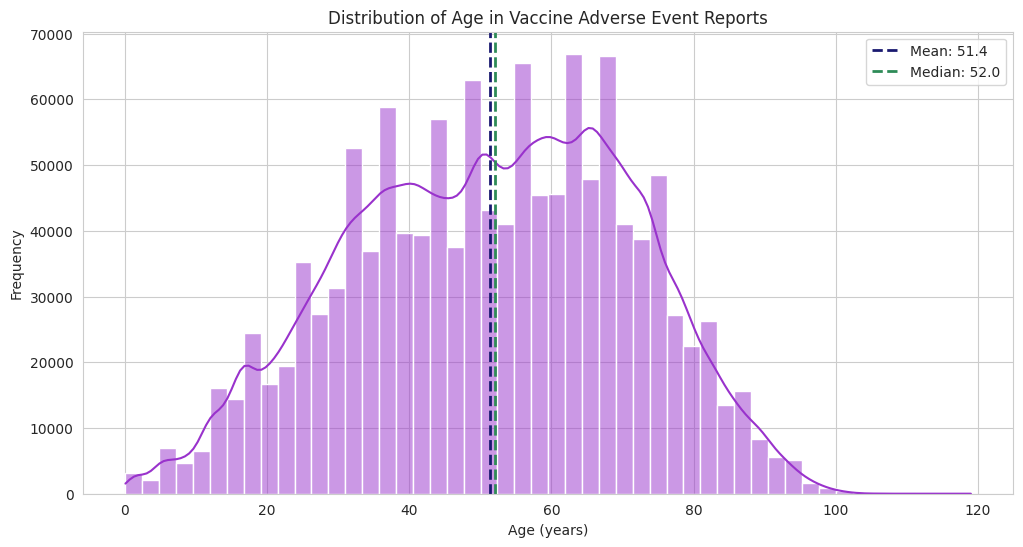

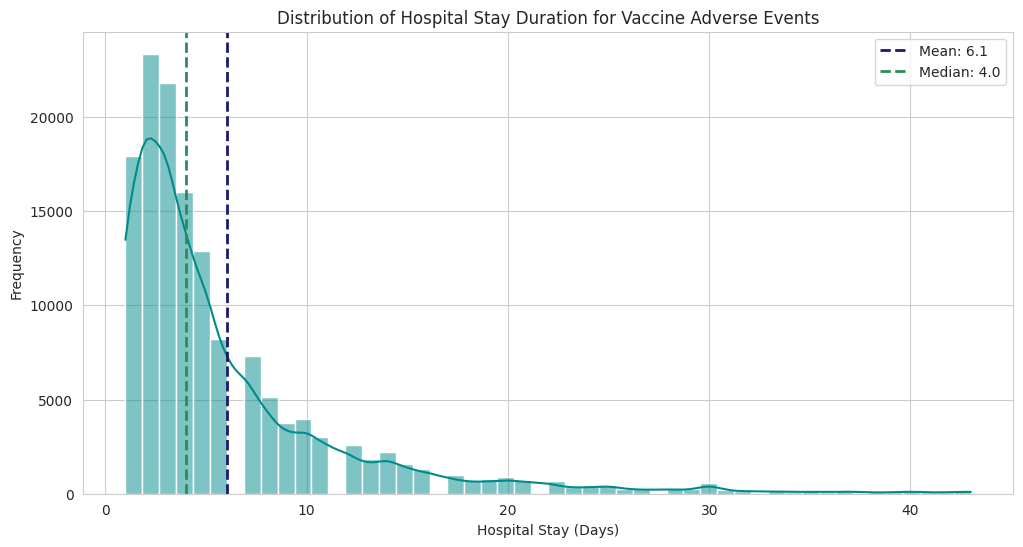

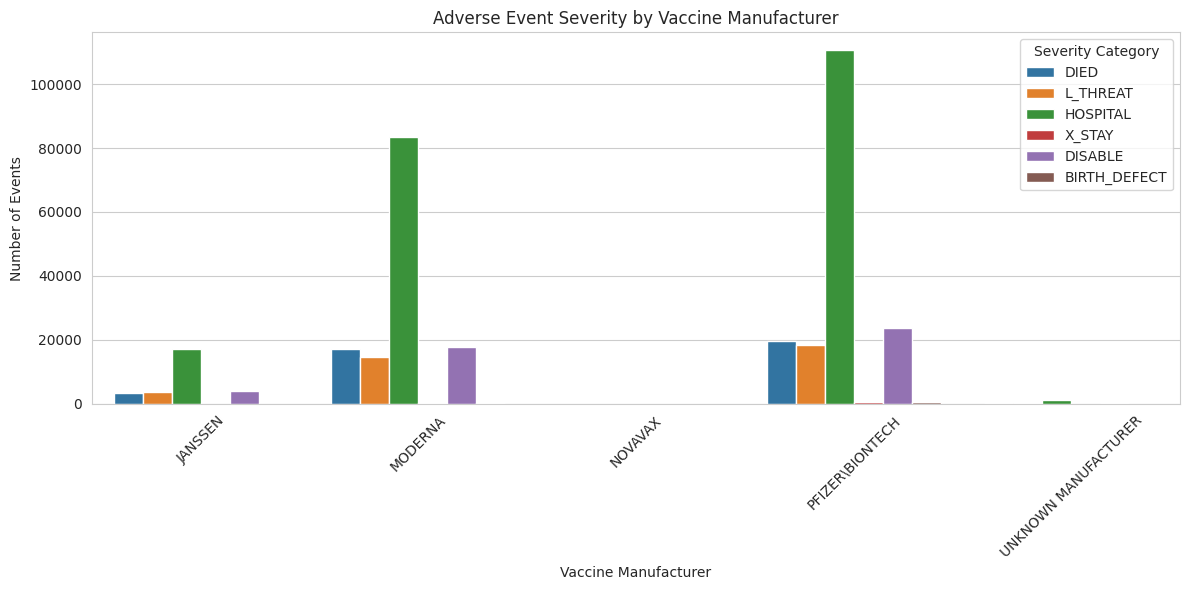

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Histogram with KDE for Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(covid_data_df['AGE_YRS'].dropna(), kde=True, bins=50, color='darkorchid')
plt.title('Distribution of Age in Vaccine Adverse Event Reports')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

# Mark mean and median
mean_age = covid_data_df['AGE_YRS'].mean()
median_age = covid_data_df['AGE_YRS'].median()
plt.axvline(mean_age, color='midnightblue', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='seagreen', linestyle='--', linewidth=2, label=f'Median: {median_age:.1f}')
plt.legend()
plt.show()

# Filter extreme outliers for visualization purposes
hospital_stays = covid_data_df[covid_data_df['HOSPDAYS'] < covid_data_df['HOSPDAYS'].quantile(0.99)]['HOSPDAYS'].dropna()

plt.figure(figsize=(12, 6))
sns.histplot(hospital_stays, bins=50, kde=True, color='darkcyan')
plt.title('Distribution of Hospital Stay Duration for Vaccine Adverse Events')
plt.xlabel('Hospital Stay (Days)')
plt.ylabel('Frequency')

# Mark mean and median
mean_stay = hospital_stays.mean()
median_stay = hospital_stays.median()
plt.axvline(mean_stay, color='midnightblue', linestyle='--', linewidth=2, label=f'Mean: {mean_stay:.1f}')
plt.axvline(median_stay, color='seagreen', linestyle='--', linewidth=2, label=f'Median: {median_stay:.1f}')
plt.legend()
plt.show()

#Aggregate outcome data
severity_counts = covid_data_df.groupby('VAX_MANU', as_index=False)[
    ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']
].sum()

# Melt aggregated dataframe
severity_counts_melted = pd.melt(
    severity_counts,
    id_vars='VAX_MANU',
    var_name='Severity',
    value_name='Count'
)

del severity_counts

# Step 2: Plotting with minimal data
plt.figure(figsize=(12, 6))
sns.barplot(
    data=severity_counts_melted,
    x='VAX_MANU',
    y='Count',
    hue='Severity'
)

plt.title('Adverse Event Severity by Vaccine Manufacturer')
plt.xlabel('Vaccine Manufacturer')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.legend(title='Severity Category')
plt.tight_layout()
plt.show()

Our initial analysis of vaccine lot information seemed to show some vaccine lots with large amounts of adverse events. Let's take a closer look.

<ipython-input-16-3642c7de183b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_lots.index, x=top_lots.values, palette='viridis')


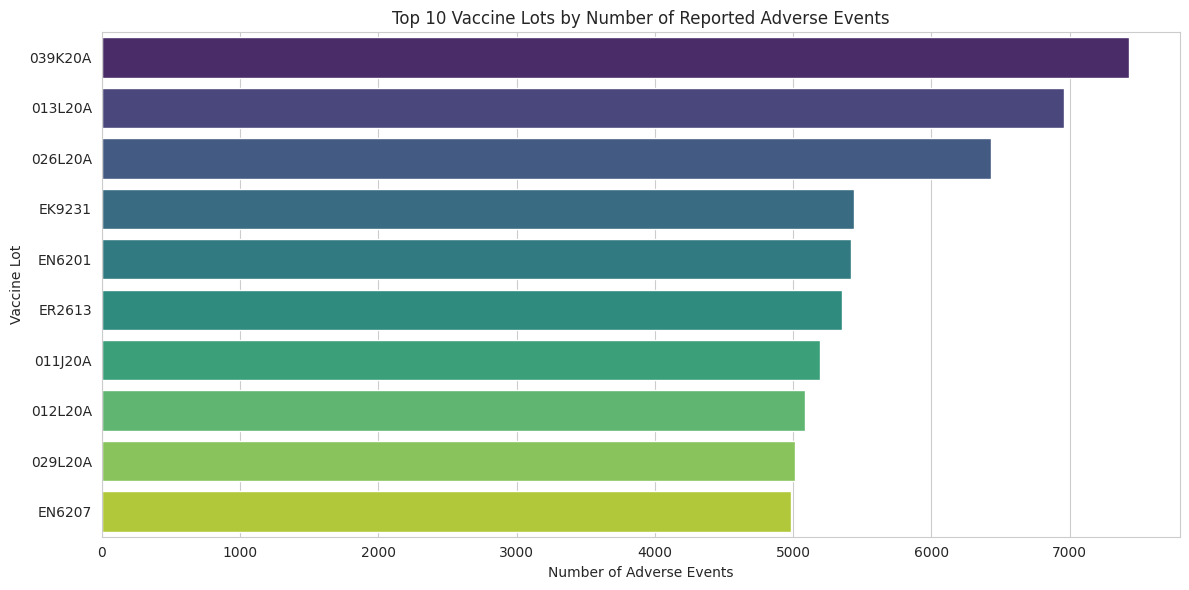

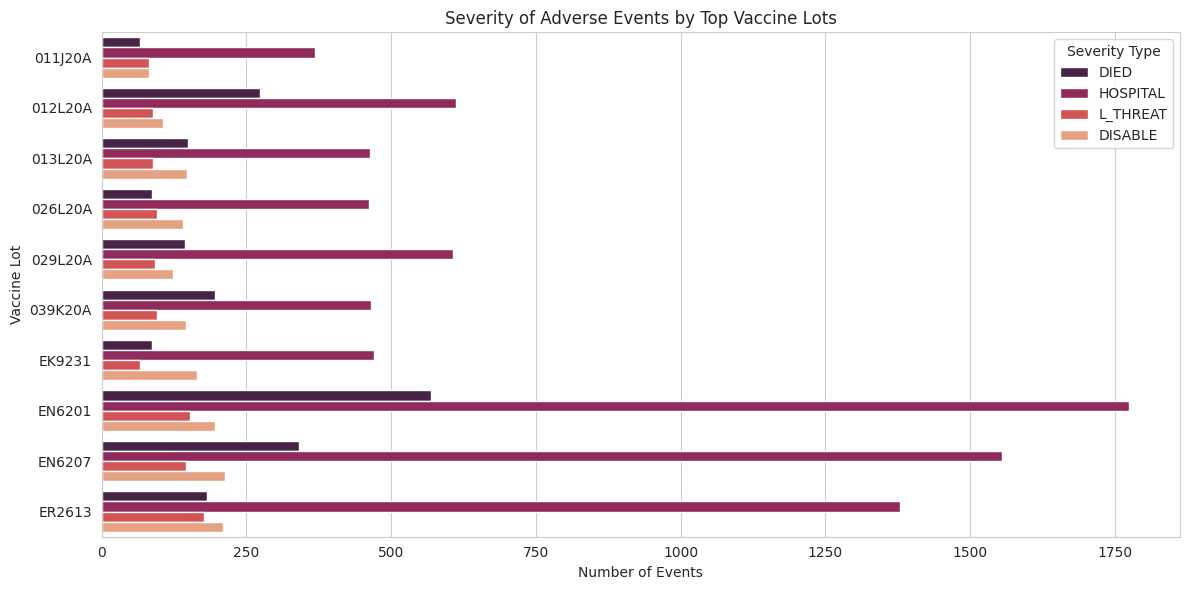

In [16]:
# Exclude 'Unknown' lots
filtered_df = covid_data_df[covid_data_df['VAX_LOT'].str.lower() != 'unknown']

# Identify top 10 vaccine lots by adverse event count
top_lots = filtered_df['VAX_LOT'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=top_lots.index, x=top_lots.values, palette='viridis')

plt.title('Top 10 Vaccine Lots by Number of Reported Adverse Events')
plt.xlabel('Number of Adverse Events')
plt.ylabel('Vaccine Lot')
plt.tight_layout()
plt.show()

# Filter data for top 10 lots only
top_lot_data = covid_data_df[covid_data_df['VAX_LOT'].isin(top_lots.index)]

# Aggregate severity counts per lot
severity_by_lot = top_lot_data.groupby('VAX_LOT')[['DIED', 'HOSPITAL', 'L_THREAT', 'DISABLE']].sum().reset_index()

# Melt for plotting
severity_by_lot_melted = severity_by_lot.melt(id_vars='VAX_LOT', var_name='Severity', value_name='Count')

# Plot grouped bar chart of severity by vaccine lot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=severity_by_lot_melted,
    x='Count',
    y='VAX_LOT',
    hue='Severity',
    palette='rocket'
)

plt.title('Severity of Adverse Events by Top Vaccine Lots')
plt.xlabel('Number of Events')
plt.ylabel('Vaccine Lot')
plt.legend(title='Severity Type')
plt.tight_layout()
plt.show()

Wow, we've uncovered something interesting here! The numbers of hospitalizations and deaths from some of these vaccine lots are exceptionally high. Let's dive deeper into the demographics and symptom co-occurrence for these concerning lots.

Filtered data shape: (30141, 48)


<ipython-input-32-7f7d11a51f9a>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=symptom_pairs_df, y='Symptom_Pair', x='Count', palette='rocket')


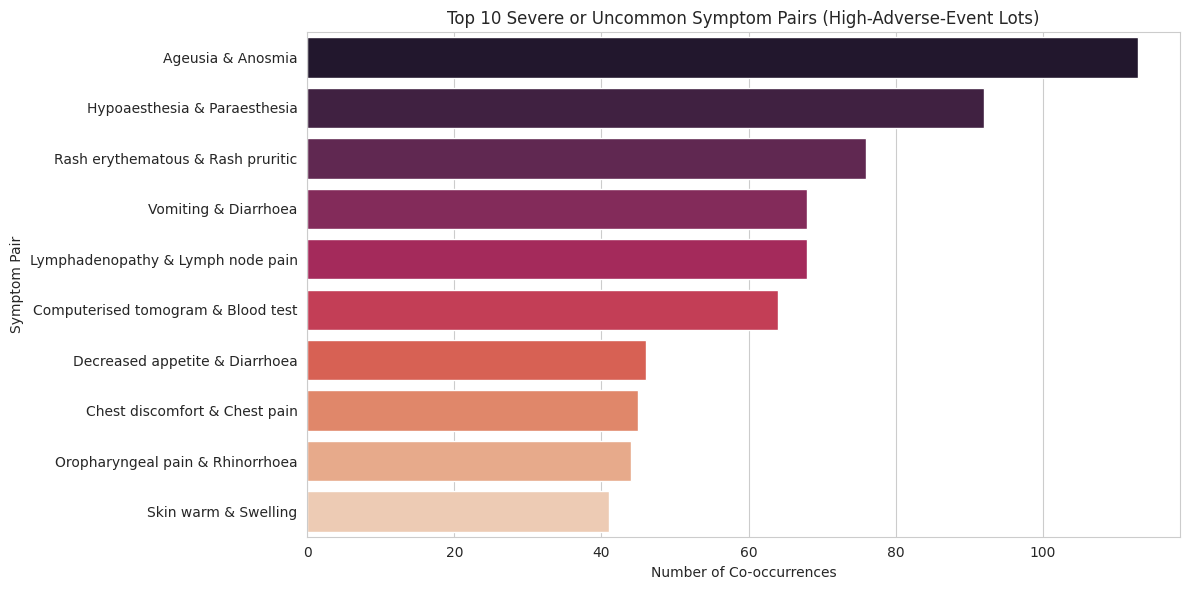

<ipython-input-32-7f7d11a51f9a>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=symptom_pairs_df, y='Symptom_Pair', x='Count', palette='rocket')


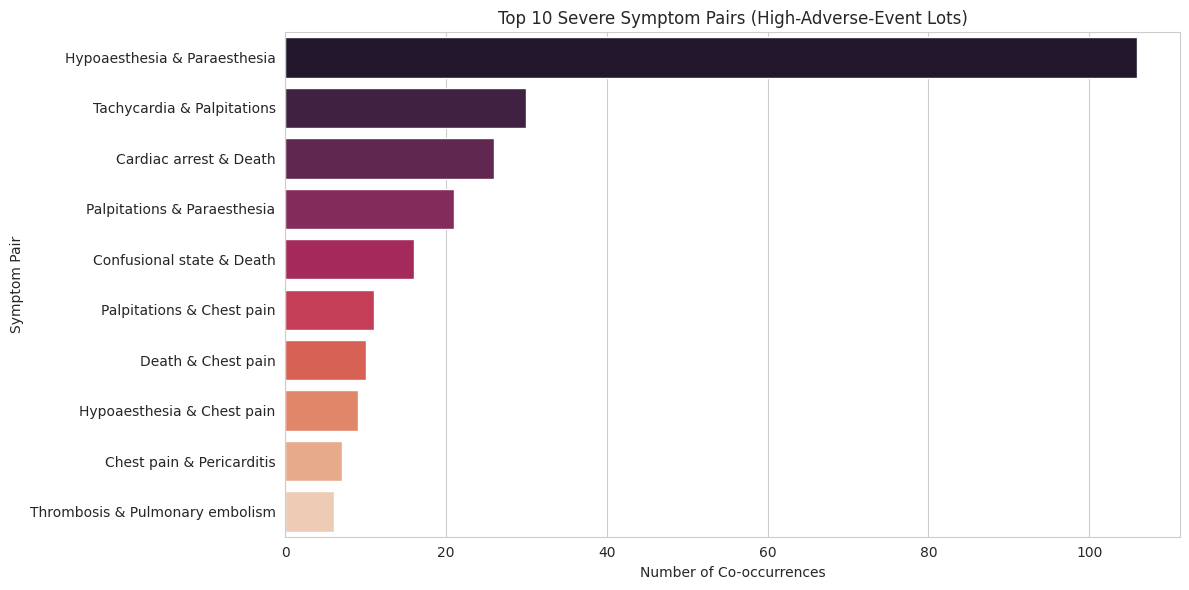

In [32]:
# Vaccine lots of interest
lots_of_interest = ['EN6201', 'EN6207', 'ER2613', '039K20A', '013L20A']

# Filter dataset for these lots
high_event_df = covid_data_df[covid_data_df['VAX_LOT'].isin(lots_of_interest)].copy()

print(f"Filtered data shape: {high_event_df.shape}")

common_mild_symptoms = {
    'Headache', 'Pyrexia', 'Fatigue', 'Chills', 'Pain', 'Pain in extremity',
    'Dizziness', 'Nausea', 'Injection site pain', 'Myalgia', 'Arthralgia',
    'Asthenia', 'Pruritus', 'Malaise', 'Feeling abnormal', 'Rash', 'Cough',
    'Injection site erythema', 'Expired product administered', 'Product storage error',
    'COVID-19', 'SARS-CoV-2 test positive', 'Vaccine breakthrough infection',
    'COVID-19 pneumonia', 'Injection site swelling', 'Injection site warmth',
    'Injection site pruritus', 'Vaccination site swelling',
    'Vaccination site pain', 'Vaccination site warmth', 'Dyspnoea',
    'Vaccination site pruritus', 'Erythema', 'Vaccination site erythema'
}

# Combine symptom columns into one list per record, ignoring NaNs
symptom_cols = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']

high_event_df['SYMPTOM_LIST'] = high_event_df[symptom_cols].apply(
    lambda x: [symptom.strip() for symptom in x.dropna().values], axis=1
)

# Filter symptom lists to remove mild symptoms
high_event_df['FILTERED_SYMPTOMS'] = high_event_df['SYMPTOM_LIST'].apply(
    lambda symptoms: [symptom for symptom in symptoms if symptom not in common_mild_symptoms]
)

from collections import Counter
from itertools import combinations
import pandas as pd

pair_counter = Counter()

for symptoms in high_event_df['FILTERED_SYMPTOMS']:
    unique_symptoms = set(symptoms)
    if len(unique_symptoms) >= 2:  # Ensure there are symptom pairs to count
        pairs = combinations(unique_symptoms, 2)
        pair_counter.update(pairs)

# Convert to DataFrame and get top 10 pairs
symptom_pairs_df = pd.DataFrame(pair_counter.items(), columns=['Symptom_Pair', 'Count']) \
                      .sort_values(by='Count', ascending=False).head(10)

# Convert tuples into readable strings for plotting
symptom_pairs_df['Symptom_Pair'] = symptom_pairs_df['Symptom_Pair'].apply(lambda x: f'{x[0]} & {x[1]}')

# Plot again with filtered data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=symptom_pairs_df, y='Symptom_Pair', x='Count', palette='rocket')

plt.title('Top 10 Severe or Uncommon Symptom Pairs (High-Adverse-Event Lots)')
plt.xlabel('Number of Co-occurrences')
plt.ylabel('Symptom Pair')
plt.tight_layout()
plt.show()

#looking for specific serious symptoms
serious_symptoms = {
    'Death', 'Cardiac arrest', 'Myocarditis', 'Pericarditis', 'Stroke', 'Thrombosis',
    'Pulmonary embolism', 'Seizure', 'Paralysis', 'Anaphylactic reaction',
    'Guillain-Barre syndrome', 'Chest pain', 'Tachycardia', 'Palpitations',
    'Neurological symptom', 'Confusional state', 'Vision blurred', 'Speech disorder',
    'Syncope', 'Facial paralysis', 'Hypoaesthesia', 'Paraesthesia'
}

high_event_df['SERIOUS_SYMPTOMS'] = high_event_df['SYMPTOM_LIST'].apply(
    lambda symptoms: [symptom for symptom in symptoms if symptom in serious_symptoms]
)

pair_counter = Counter()

for symptoms in high_event_df['SERIOUS_SYMPTOMS']:
    unique_symptoms = set(symptoms)
    if len(unique_symptoms) >= 2:  # Ensure there are symptom pairs to count
        pairs = combinations(unique_symptoms, 2)
        pair_counter.update(pairs)

# Convert to DataFrame and get top 10 pairs
symptom_pairs_df = pd.DataFrame(pair_counter.items(), columns=['Symptom_Pair', 'Count']) \
                      .sort_values(by='Count', ascending=False).head(10)

# Convert tuples into readable strings for plotting
symptom_pairs_df['Symptom_Pair'] = symptom_pairs_df['Symptom_Pair'].apply(lambda x: f'{x[0]} & {x[1]}')

# Plot again with filtered data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=symptom_pairs_df, y='Symptom_Pair', x='Count', palette='rocket')

plt.title('Top 10 Severe Symptom Pairs (High-Adverse-Event Lots)')
plt.xlabel('Number of Co-occurrences')
plt.ylabel('Symptom Pair')
plt.tight_layout()
plt.show()


Next, we focus in on demographic information to look for more complex patterns and relationships.

In [14]:
#create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 119]
labels = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
covid_data_df['AGE_GROUP'] = pd.cut(covid_data_df['AGE_YRS'], bins=bins, labels=labels, right=False)

# Distribution of adverse events by age group
age_group_counts = covid_data_df['AGE_GROUP'].value_counts().sort_index()
print("Distribution of Adverse Events by Age Group:")
print(age_group_counts)

# Distribution of adverse events by sex
sex_counts = covid_data_df['SEX'].value_counts(dropna=False)
print("\nDistribution of Adverse Events by Sex:")
print(sex_counts)

# Distribution of adverse events by state
state_counts = covid_data_df['STATE'].value_counts(dropna=False)
print("\nDistribution of Adverse Events by State:")
print(state_counts.head(10))  # Display top 10 states

Distribution of Adverse Events by Age Group:
AGE_GROUP
0-17      63538
18-29    128688
30-39    184223
40-49    194433
50-59    217600
60-69    227088
70-79    167092
80+       88247
Name: count, dtype: int64

Distribution of Adverse Events by Sex:
SEX
F    900804
M    444268
U     44129
Name: count, dtype: int64

Distribution of Adverse Events by State:
STATE
NaN    210007
CA     128648
FL      74176
TX      72089
NY      68135
MI      68098
PA      45567
IL      40840
IN      39110
OH      38414
Name: count, dtype: int64


There are some really interesting patterns emerging from this demographic data. The most startling information at this point may be that females have twice as many adverse event reports as males! Let's explore that further and see if we can learn more.


Adverse Events by Sex:
SEX
F    900804
M    444268
U     44129
Name: count, dtype: int64

Percentage of Adverse Events by Sex:
SEX
F    64.843316
M    31.980109
U     3.176574
Name: count, dtype: float64


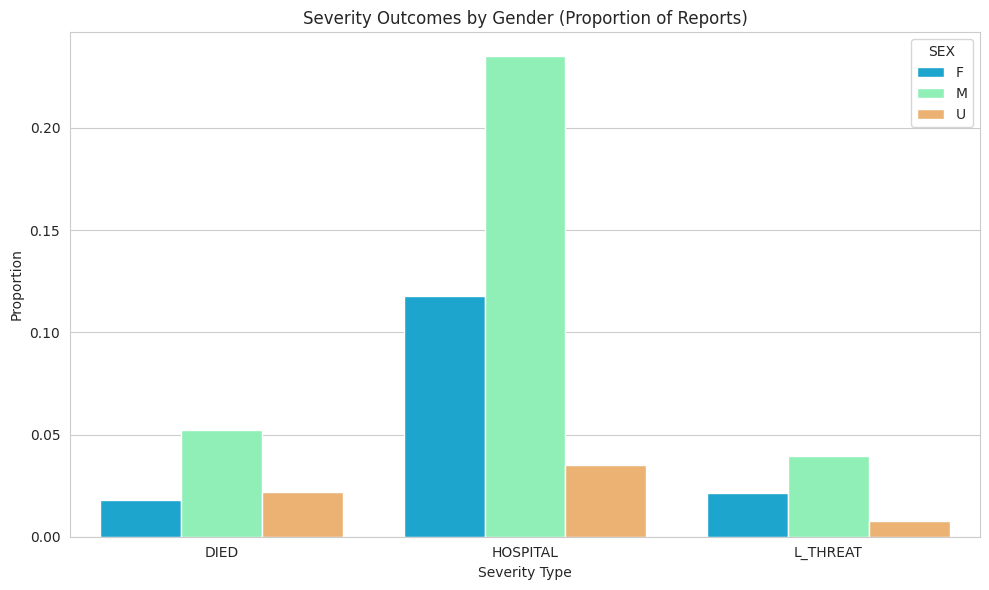


Percentage of Severe Outcomes by Sex:
  SEX  Severity  Proportion
0   F      DIED    0.018052
1   M      DIED    0.051984
2   U      DIED    0.021777
3   F  HOSPITAL    0.117911
4   M  HOSPITAL    0.235011
5   U  HOSPITAL    0.035124
6   F  L_THREAT    0.021356
7   M  L_THREAT    0.039474
8   U  L_THREAT    0.007478


In [37]:
import pandas as pd
import plotly.express as px

# Group by sex and calculate the number of adverse events
sex_counts = covid_data_df['SEX'].value_counts(dropna=False)
print("Adverse Events by Sex:")
print(sex_counts)

# Calculate the percentage of adverse events by sex
total_events = len(covid_data_df)
sex_percentages = (sex_counts / total_events) * 100
print("\nPercentage of Adverse Events by Sex:")
print(sex_percentages)

severity_gender = covid_data_df.groupby('SEX')[['DIED', 'HOSPITAL', 'L_THREAT']].mean().reset_index().melt(
    id_vars='SEX', var_name='Severity', value_name='Proportion')

plt.figure(figsize=(10,6))
sns.barplot(data=severity_gender, x='Severity', y='Proportion', hue='SEX', palette='rainbow')

plt.title('Severity Outcomes by Gender (Proportion of Reports)')
plt.xlabel('Severity Type')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


print("\nPercentage of Severe Outcomes by Sex:")
print(severity_gender)

# Count symptoms per gender
symptom_sex_counts = (
    covid_data_df
    .melt(id_vars='SEX', value_vars=symptom_cols, value_name='SYMPTOM')
    .dropna(subset=['SYMPTOM'])
    .groupby(['SEX', 'SYMPTOM'])
    .size()
    .unstack(level=0, fill_value=0)
)

# Top 10 symptoms per sex
top_female = symptom_sex_counts['F'].nlargest(10)
top_male = symptom_sex_counts['M'].nlargest(10)

# Combine unique top symptoms
combined_top_symptoms = pd.Index(top_female.index).union(top_male.index)

# Select and melt for visualization
top_symptoms_counts = symptom_sex_counts.loc[combined_top_symptoms].reset_index()
top_symptoms_counts_melted = top_symptoms_counts.melt(
    id_vars='SYMPTOM', var_name='SEX', value_name='COUNT'
)

# Plot top symptoms by sex
import plotly.express as px

fig = px.bar(
    top_symptoms_counts_melted,
    x='SYMPTOM',
    y='COUNT',
    color='SEX',
    barmode='group',
    title='Top Symptoms by Sex (Combined Top 10)',
    labels={'SYMPTOM': 'Symptom', 'COUNT': 'Count'}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


common_mild_symptoms = {
    'Headache', 'Pyrexia', 'Fatigue', 'Chills', 'Pain', 'Pain in extremity',
    'Dizziness', 'Nausea', 'Injection site pain', 'Myalgia', 'Arthralgia',
    'Asthenia', 'Pruritus', 'Malaise', 'Feeling abnormal', 'Rash', 'Cough',
    'Injection site erythema', 'Expired product administered', 'Product storage error',
    'COVID-19', 'SARS-CoV-2 test positive', 'SARS-CoV-2 test', 'Vaccine breakthrough infection',
    'COVID-19 pneumonia', 'Injection site swelling', 'Injection site warmth',
    'Injection site pruritus', 'Vaccination site swelling',
    'Vaccination site pain', 'Vaccination site warmth', 'Dyspnoea',
    'Vaccination site pruritus', 'Erythema', 'Vaccination site erythema',
    'No adverse event'
}
#repeat with the most common and mild symptoms omitted

# Filter out mild/common symptoms
symptom_sex_counts_filtered = symptom_sex_counts[~symptom_sex_counts.index.isin(common_mild_symptoms)]

# Recalculate top symptoms after filtering
top_female_filtered = symptom_sex_counts_filtered['F'].nlargest(10)
top_male_filtered = symptom_sex_counts_filtered['M'].nlargest(10)
combined_top_symptoms_filtered = pd.Index(top_female_filtered.index).union(top_male_filtered.index)

top_symptoms_counts_filtered = symptom_sex_counts_filtered.loc[combined_top_symptoms_filtered].reset_index()
top_symptoms_counts_melted_filtered = top_symptoms_counts_filtered.melt(
    id_vars='SYMPTOM', var_name='SEX', value_name='COUNT'
)

# Plot filtered data
fig_filtered = px.bar(
    top_symptoms_counts_melted_filtered,
    x='SYMPTOM',
    y='COUNT',
    color='SEX',
    barmode='group',
    title='Top Severe or Uncommon Symptoms by Sex',
    labels={'SYMPTOM': 'Symptom', 'COUNT': 'Count'}
)
fig_filtered.update_layout(xaxis_tickangle=-45)
fig_filtered.show()

In [39]:
import pandas as pd
import plotly.express as px

# Load the population data
population_data = pd.read_csv('/content/drive/My Drive/VAERS2021to2024/USPopByState.csv')
population_data.columns = ['STATE', 'Population']  # Ensure column names match

population_data['STATE'] = population_data['STATE'].str.replace('.', '', regex=False)
population_data['STATE'] = population_data['STATE'].str.strip()

print(population_data.head())
# Create a mapping from abbreviated state names to full state names
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

population_data['STATE_ABV'] = population_data['STATE'].map(state_mapping)

merged_data = pd.merge(covid_data_df, population_data, left_on='STATE', right_on='STATE_ABV', how='left')


#Drop rows with NaN values
merged_data = merged_data.dropna(subset=['Population'])

#calculate adverse events per state
state_counts = merged_data.groupby('STATE_ABV').size().reset_index(name='AdverseEvents')


# Normalize the adverse events per 100,000 population
normalized_data = pd.merge(state_counts, population_data, left_on='STATE_ABV', right_on='STATE_ABV')
normalized_data['Population'] = normalized_data['Population'].fillna(0)
normalized_data['Population'] = normalized_data['Population'].astype(float)
normalized_data['Population'] = normalized_data['Population'] / 100000
normalized_data['NormalizedEvents'] = (normalized_data['AdverseEvents'] / normalized_data['Population'])

# Display the normalized data
print(normalized_data[['STATE_ABV', 'AdverseEvents', 'Population', 'NormalizedEvents']].sort_values('NormalizedEvents', ascending=False).head(10))

# Visualize the normalized data using a choropleth map
fig = px.choropleth(normalized_data,
                    locations='STATE_ABV',
                    locationmode="USA-states",
                    color='NormalizedEvents',
                    color_continuous_scale="YlOrRd",
                    scope="usa",
                    labels={'NormalizedEvents':'Adverse Events per 100,000 Population'},
                    title='Normalized Adverse Events by State (per 100,000 Population)')

fig.show()

        STATE  Population
0     Alabama     5157699
1      Alaska      740133
2     Arizona     7582384
3    Arkansas     3088354
4  California    39431263
   STATE_ABV  AdverseEvents  Population  NormalizedEvents
21        MI          68098   101.40459        671.547511
22        MN          34244    57.93151        591.111815
14        IN          39110    69.24275        564.824476
45        VT           3466     6.48493        534.469917
16        KY          23482    45.88372        511.771931
5         CO          28649    59.57493        480.890200
0         AK           3471     7.40133        468.969766
29        NH           6576    14.09032        466.703382
20        ME           6476    14.05012        460.921330
6         CT          16378    36.75069        445.651497


In [51]:
#geographic analysis of notable vaccine lots

# Filter by lots_of_interest first
filtered_df = covid_data_df[covid_data_df['VAX_LOT'].isin(lots_of_interest)]

# Then groupby and count
lot_state_counts = filtered_df.groupby(['STATE', 'VAX_LOT']).size().reset_index(name='COUNT')

# Pivot data for clarity
lot_state_pivot = lot_state_counts.pivot(index='STATE', columns='VAX_LOT', values='COUNT').fillna(0).reset_index()


fig = px.choropleth(
    lot_state_pivot,
    locations='STATE',
    locationmode="USA-states",
    color='EN6201',
    color_continuous_scale='viridis',
    scope="usa",
    labels={'EN6201':'Reports'},
    title='Geographic Distribution of Lot EN6201'
)
fig.show()

fig = px.choropleth(
    lot_state_pivot,
    locations='STATE',
    locationmode="USA-states",
    color='EN6207',
    color_continuous_scale='curl',
    scope="usa",
    labels={'EN6207':'Reports'},
    title='Geographic Distribution of Lot EN6207'
)
fig.show()

fig = px.choropleth(
    lot_state_pivot,
    locations='STATE',
    locationmode="USA-states",
    color='ER2613',
    color_continuous_scale='delta',
    scope="usa",
    labels={'ER2613':'Reports'},
    title='Geographic Distribution of Lot ER2613'
)
fig.show()

fig = px.choropleth(
    lot_state_pivot,
    locations='STATE',
    locationmode="USA-states",
    color='039K20A',
    color_continuous_scale='agsunset',
    scope="usa",
    labels={'039K20A':'Reports'},
    title='Geographic Distribution of Lot 039K20A'
)
fig.show()

fig = px.choropleth(
    lot_state_pivot,
    locations='STATE',
    locationmode="USA-states",
    color='013L20A',
    color_continuous_scale='geyser',
    scope="usa",
    labels={'013L20A':'Reports'},
    title='Geographic Distribution of Lot 013L20A'
)
fig.show()

Let's move on to some temporal analysis to see if and how adverse reactions changed between 2021 and 2024.

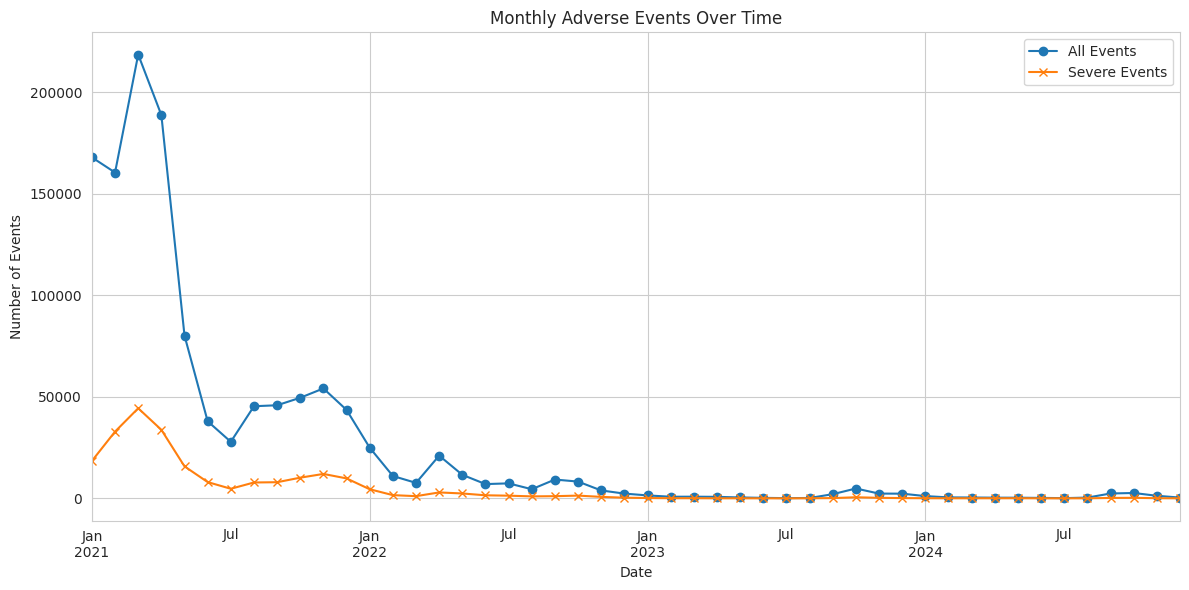

<ipython-input-72-4d948e7e1521>:29: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



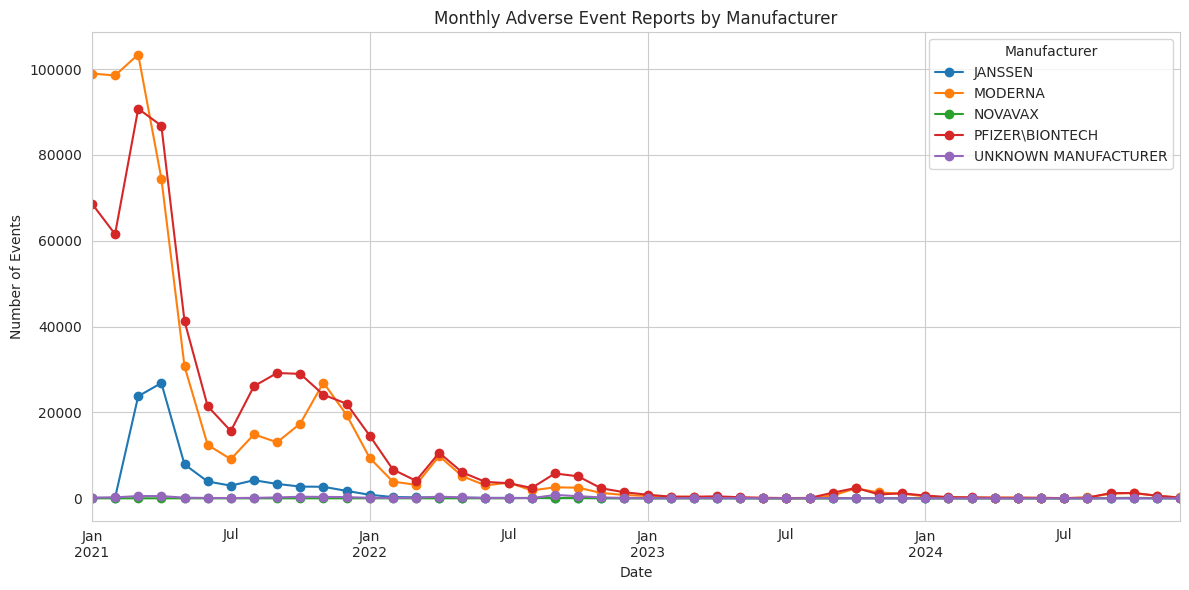

In [72]:
# Re-convert to datetime explicitly
covid_data_df['VAX_DATE'] = pd.to_datetime(covid_data_df['VAX_DATE'], errors='coerce')

# Filter out unrealistic dates
start_date = '2021-01-01'
filtered_df = covid_data_df[covid_data_df['VAX_DATE'] >= start_date]

# Ensure datetime index is set correctly
filtered_df = filtered_df.set_index('VAX_DATE')
filtered_df = filtered_df.sort_index()  # Sorting helps resampling stability

# Use 'ME' (month-end) instead of deprecated 'M'
monthly_events = filtered_df.resample('ME').size()

# Monthly severe events (death, hospitalization, life-threatening)
monthly_severe = filtered_df[filtered_df[['DIED', 'HOSPITAL', 'L_THREAT']].any(axis=1)].resample('ME').size()

# Plot
plt.figure(figsize=(12, 6))
monthly_events.plot(label='All Events', marker='o')
monthly_severe.plot(label='Severe Events', marker='x')
plt.title('Monthly Adverse Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.tight_layout()
plt.show()

manufacturer_monthly = filtered_df.groupby('VAX_MANU').resample('ME').size().unstack(0).fillna(0)

manufacturer_monthly.plot(figsize=(12,6), marker='o')
plt.title('Monthly Adverse Event Reports by Manufacturer')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend(title='Manufacturer')
plt.tight_layout()
plt.show()


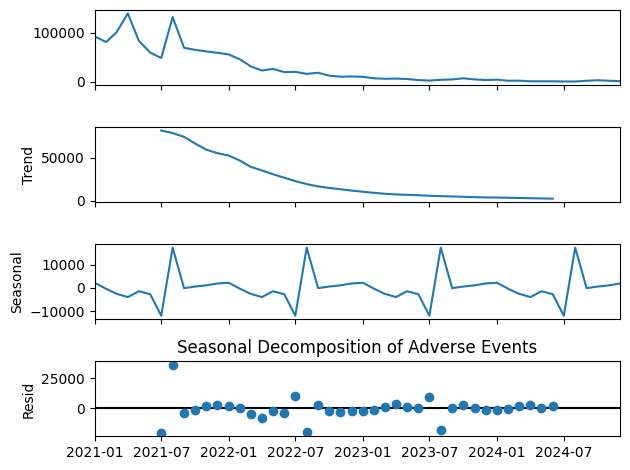

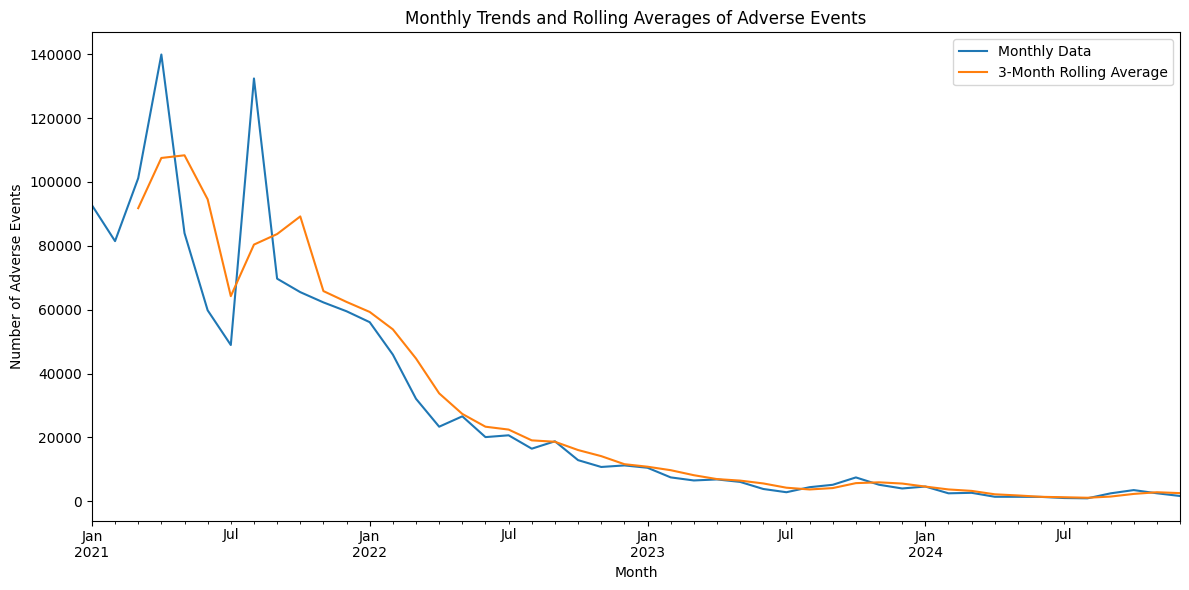

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt

# Convert RECVDATE to datetime if not already done
covid_data_df['RECVDATE'] = pd.to_datetime(covid_data_df['RECVDATE'])

# Monthly trends
monthly_trends = covid_data_df.groupby(covid_data_df['RECVDATE'].dt.to_period('M')).size()

# Convert PeriodIndex to DatetimeIndex for plotting
monthly_trends.index = monthly_trends.index.to_timestamp()

# Seasonal Decomposition
result = seasonal_decompose(monthly_trends, model='additive', period=12)
result.plot()
plt.title('Seasonal Decomposition of Adverse Events')
plt.tight_layout()
plt.show()

# Rolling Averages
rolling_avg = monthly_trends.rolling(window=3).mean()
plt.figure(figsize=(12, 6))
monthly_trends.plot(label='Monthly Data')
rolling_avg.plot(label='3-Month Rolling Average')
plt.title('Monthly Trends and Rolling Averages of Adverse Events')
plt.xlabel('Month')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-84-5c4b2d0326f7>:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




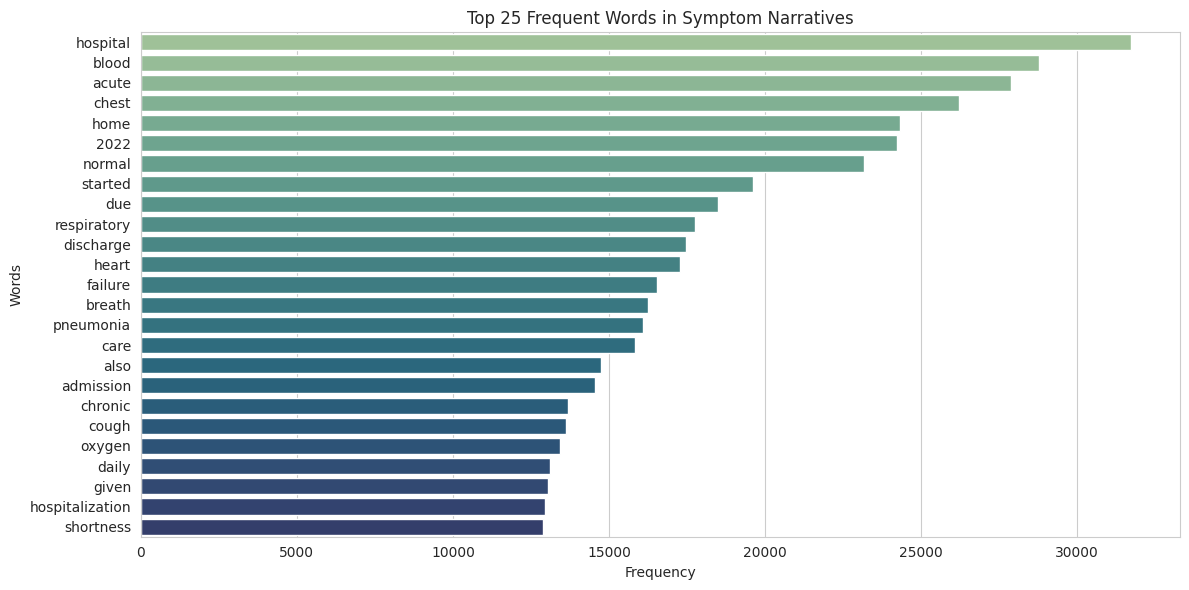

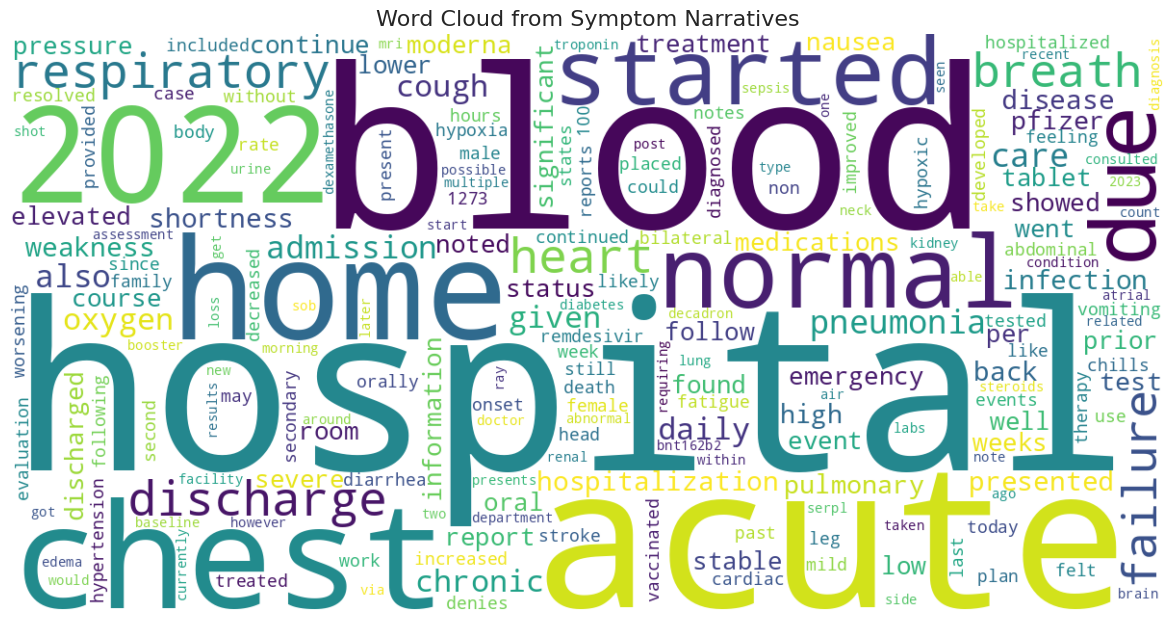

In [84]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter

nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))
additional_stopwords = {'patient', 'reported', 'received', 'covid', 'vaccine', 'dose', 'vaccination',
                        'symptom', 'pain', 'vaccination', 'unknown', 'mrna', 'date', 'injection',
                        'history', 'experienced', 'site', 'days', 'day', 'medical', 'outcome', 'first',
                        'time', 'fever', 'headache', 'swelling', '2021', 'left', 'right', 'arm', 'information'
                        'report', 'lot', 'symptoms', 'year', 'old', 'number', 'unspecified', '2022'
                        'hospital', 'positive', 'negative', 'admitted'}
stop_words = stop_words.union(additional_stopwords)

# Clean and preprocess text data
def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())  # remove punctuation and lowercase
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return words

# Apply cleaning (sample a subset first if too large)
sample_size = 50000  # adjust as needed based on your RAM
severe_df = covid_data_df[covid_data_df[['DIED', 'HOSPITAL', 'L_THREAT']].any(axis=1)]
sampled_text = severe_df['SYMPTOM_TEXT'].dropna().sample(sample_size, random_state=42)

all_words = []
for text in sampled_text:
    all_words.extend(clean_text(text))

# Word frequency
word_freq = Counter(all_words)
common_words = word_freq.most_common(25)

# Bar plot of common words
common_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12,6))
sns.barplot(data=common_df, y='Word', x='Count', palette='crest')
plt.title('Top 25 Frequent Words in Symptom Narratives')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Symptom Narratives', fontsize=16)
plt.show()
